#  Modelado de Topics

**Topic Modelling** 

Conjunto de técnicas para descubrir estructuras latentes semánticas comunes (topics o temas) en un conjunto de documentos.

Consiste en identificar tópicos o temas en textos, detectando patrones en una colección de documentos "corpus" y agrupando las palabras que aparecen en los documentos.

*Topic Modelling generativo* es un modelo que permite la clasificación de documentos aún no procesados una vez que el modelo fue entrenado sin pasar por el corpus entero.

**LDA (Algoritmo Latent Dirichlet Allocation)** 

Es un modelo de topics probabilístico generativo, es decir asume que cada palabra en un documento es generada a partir de un topic que es tomado de una distribución de topics para cada documento. 

LDA permite que un documento sea parte de varios topics, cada uno con un peso diferente, es decir un documento es una distribución de topics y un topic es una distribución de palabras.

Este algoritmo asume:

- Documentos con topics similares usarán palabras similares
- Documentos compuestos por un conjunto de topics (con una determinada distribución)
- Topics compuestos por un conjunto de palabras (con una determinada distribución)

### Etapas

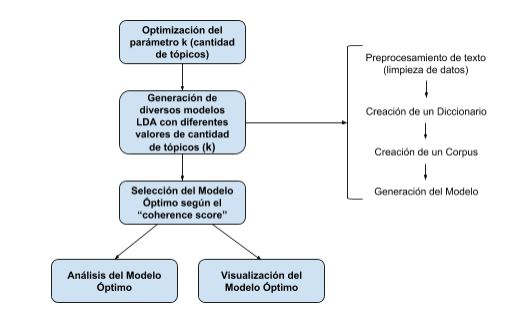

### Librerías y funciones necesarias

In [1]:
# Librería gensim (complementaria a Spacy)
# Librería pyLDAvis 
!pip install gensim
!pip install pyLDAvis

In [2]:
import random
import pandas as pd
import numpy as np

import gensim
from gensim.corpora import Dictionary  # Diccionario clave:valor
from gensim.models import LdaModel, CoherenceModel  # Modelo LDA

import pyLDAvis  # Visualizar los clusters
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Sets the value of the specified option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')

### Lectura de datos

In [4]:
# Lectura del dataset con los reviews de amazon descargados en el notebook 0_AnalisisSentimientos_sintratamiento.ipynb
# Son 20000 tweets sobre music, clothing, health and sports con 5000 por subset balanceados por overall de 1 a 5
df_amazon = pd.read_pickle('df_amazoncompleto.pkl')
print(f'Dimensiones del dataset son: {df_amazon.shape}')

Dimensiones del dataset son: (20000, 9)


In [5]:
# Visualizamos las primeras filas
df_amazon.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A319Y60NW7HS77,B000001EGI,"radiogold ""radiogold""","[2, 21]",Tumbleweed Connection raised Elton to his init...,1.0,"Just a brief dip, he would improve again!",1084752000,"05 17, 2004"
1,A15HQSBVCU724Y,B0002XEDSU,Mikky Mouse,"[3, 4]",Im not gonna review on this.. all i can say is...,1.0,That White Tee song is retarded,1134000000,"12 8, 2005"
2,AZ39SOZT3NZQU,B000FVQYYK,XraySpex,"[4, 67]",I bought this album because I went to a lyric ...,1.0,Put This In A Black Hole,1184544000,"07 16, 2007"
3,A36489F4G8T4E7,B000075A20,Edgar Sanchez,"[5, 9]",This poorly made and horrible album is reason ...,1.0,DONT PAY THE COST FOR THIS ...,1064102400,"09 21, 2003"
4,A3NL33GFYHE72V,B0006ZQ9BS,"music fan ""music fan""","[2, 6]",This album was a big disappointment. It doesn...,1.0,NO!!!!,1106092800,"01 19, 2005"


In [6]:
# Análisis de la columna retweet
check_column(df_amazon, 'reviewText')
df_amazon['reviewText'].value_counts().head()

reviewText consta de: 19995 valores distintos de un total de 20000
reviewText consta de: 0 valores ausentes, 0.0%


In [7]:
# Análisis de la columna overall --> muestra balanceada
check_column(df_amazon, 'overall')
df_amazon['overall'].value_counts().head()

overall consta de: 5 valores distintos de un total de 20000
overall consta de: 0 valores ausentes, 0.0%


5.0    4000
4.0    4000
3.0    4000
2.0    4000
1.0    4000
Name: overall, dtype: int64

In [8]:
# Nos quedamos únicamente con la columna reviewText correspondiente al review de los df de Amazon
df_amazon = df_amazon[['reviewText']]
print(f'Dimensiones del dataset son: {df_amazon.shape}')
# No es necesario porque dicha columna no contiene valores ausentes pero lo contemplo 
# para futuros procesados de otros datasets que si contengan valores ausentes.
df_amazon.dropna(inplace=True)
print(f'Dimensiones del dataset son: {df_amazon.shape}')

Dimensiones del dataset son: (20000, 1)
Dimensiones del dataset son: (20000, 1)


### Muestra de 2500 reviews

In [9]:
# Nos quedamos con una muestra aleatora de 2500 registros
# random_state = 1 repetitibidad en los resultados obtenidos
df_amazonfilter = df_amazon.sample(2500, random_state=1)
print(f'Dimensiones del dataset son: {df_amazonfilter.shape}')

Dimensiones del dataset son: (2500, 1)


In [10]:
# Columnas del df
df_amazonfilter.columns

Index(['reviewText'], dtype='object')

In [11]:
# Visualizamos las primeras filas y observamos que los índices corresponden a la selección aleatoria anterior
df_amazonfilter.head(3)

,reviewText
11456,The watch does do everything it says it does. ...
16528,Hatchet arrived covered in some oily substance...
3253,"Forget the plodding, Octave. THIS is the Moood..."


In [12]:
# Reset the index, or a level of it
# drop : bool, default False.   Do not try to insert index into dataframe columns. 
# This resets the index to the default integer index.
# inplace : bool, default False.  Modify the DataFrame in place (do not create a new object)
df_amazonfilter.reset_index(drop=True, inplace=True)

In [13]:
# Visualizamos las primeras filas con los índices correctos
df_amazonfilter.head(3)

,reviewText
0,The watch does do everything it says it does. ...
1,Hatchet arrived covered in some oily substance...
2,"Forget the plodding, Octave. THIS is the Moood..."


### Preprocesado

Aplicamos gensim.utils.simple_preprocess: Convert a document into a list of lowercase tokens, 

     ignoring tokens that are too short or too long.
     doc : str.     Input document.
     deacc : bool, optional.     Remove accent marks from tokens using :func:`~gensim.utils.deaccent`?
     min_len : int, optional.    Minimum length of token (inclusive). Shorter tokens are discarded.
     max_len : int, optional.    Maximum length of token in result (inclusive). Longer tokens are discarded.

In [14]:
# Función que realiza el preprocesado utilizando las librerías de gensim.utils.simple_preprocess
def text_preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [15]:
print('Original text:\n{}\n\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:\n{}'.format(text_preprocessing(df_amazonfilter['reviewText'][2])))

Original text:
Forget the plodding, Octave. THIS is the Mooody Blues comeback album.Most of the songs here are fantastic. The band is re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." is the best John Lodge solo vocal on any Moody Blues album from any era. "In My World" is a worthy addition to the Justin Hayward ballad catalogue. The only criticism is the Ray Thomas songs are not on par with his classic work, and, consequently, are the weakest songs on the album.


Processed text:
['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'songs', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'best', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'songs', 'classic', 'work', 'consequently', 'weakest', 'songs', 'album']


In [16]:
# lista de lista de documentos
processed_texts = []
for text in df_amazonfilter['reviewText']:
    processed_texts.append(text_preprocessing(text))

In [17]:
# Dimensiones del procesado de textos
len(processed_texts)

2500

In [18]:
# processed_texts[2] = text_preprocessing(df['text'][2])
print(processed_texts[2], '\n')
print('Original text:\n{}\n\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:\n{}'.format(text_preprocessing(df_amazonfilter['reviewText'][2])))

['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'songs', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'best', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'songs', 'classic', 'work', 'consequently', 'weakest', 'songs', 'album'] 

Original text:
Forget the plodding, Octave. THIS is the Mooody Blues comeback album.Most of the songs here are fantastic. The band is re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." is the best John Lodge solo vocal on any Moody Blues album from any era. "In My World" is a worthy addition to the Justin Hayward ballad catalogue. The only criticism is the Ray Thomas songs are not on par with his classic work, and, consequently, are the weakest songs on the album.


Processed text:
['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'songs', 'fant

In [19]:
processed_texts[2] == text_preprocessing(df_amazonfilter['reviewText'][2])

True

### Diccionario 

In [20]:
# Función que genera un diccionario id-palabra a partir de unos textos
def get_dictionary (texts) :
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = Dictionary (texts)
    # dictionary . filter_extremes ( no_below =20 , no_above =0.5)
    # remove_n = 5 means number of the most frequent tokens that will be removed 
    dictionary.filter_n_most_frequent (5)
    return dictionary

In [21]:
# Creación de un diccionario id-palabra
dictionary = get_dictionary(processed_texts)
print(f'Longitud del diccionario: ', {len(dictionary)})

print('Diccionario id,palabra: ')
list(dictionary.items())

Longitud del diccionario:  {15663}
Diccionario id,palabra: 


[(0, 'away'),
 (1, 'bunch'),
 (2, 'certainly'),
 (3, 'controls'),
 (4, 'downloading'),
 (5, 'effort'),
 (6, 'expensive'),
 (7, 'extra'),
 (8, 'figure'),
 (9, 'friendly'),
 (10, 'hard'),
 (11, 'heart'),
 (12, 'information'),
 (13, 'instructions'),
 (14, 'interaction'),
 (15, 'interface'),
 (16, 'intuitive'),
 (17, 'iphone'),
 (18, 'know'),
 (19, 'monitor'),
 (20, 'occasional'),
 (21, 'payoff'),
 (22, 'pulling'),
 (23, 'real'),
 (24, 'running'),
 (25, 'says'),
 (26, 'software'),
 (27, 'spend'),
 (28, 'teeth'),
 (29, 'throwing'),
 (30, 'times'),
 (31, 'user'),
 (32, 'wanted'),
 (33, 'watch'),
 (34, 'watches'),
 (35, 'week'),
 (36, 'work'),
 (37, 'working'),
 (38, 'worse'),
 (39, 'worth'),
 (40, 'arrived'),
 (41, 'backpack'),
 (42, 'black'),
 (43, 'camp'),
 (44, 'cast'),
 (45, 'covered'),
 (46, 'curing'),
 (47, 'fits'),
 (48, 'hand'),
 (49, 'hands'),
 (50, 'hatchet'),
 (51, 'heavy'),
 (52, 'husband'),
 (53, 'iron'),
 (54, 'left'),
 (55, 'looked'),
 (56, 'marks'),
 (57, 'nicely'),
 (58, 'oi

### Matriz documento-palabra (ó término)

In [22]:
# Función que genera un corpus dado un diccionario y unos textos
def get_corpus (dictionary, texts) :
    # convert tokenized documents into a document - term matrix
    # doc2bow (document): Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus

In [23]:
# Creación de un corpus
corpus = get_corpus(dictionary, processed_texts)
print(f'Corpus: ')
corpus

Corpus: 


[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 2),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2)],
 [(40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1)],
 [(36, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 3),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 

In [24]:
# Significa que las siguientes palabras o términos con id en el vocabulario se repiten el nº de veces indicado:
# lyrics con id 115 en el diccionario se repite 3 veces
# musicians con id 118 se repite 2 veces
print('Original  text:{}\n'.format(df_amazonfilter['reviewText'][2]))
print('Processed text:{}\n'.format(processed_texts[2]))
print('Corpus        :{}'.format(corpus[2]))


Original  text:Forget the plodding, Octave. THIS is the Mooody Blues comeback album.Most of the songs here are fantastic. The band is re-energized by the arrival of Patrick Moraz. "Talking Out Of Turn." is the best John Lodge solo vocal on any Moody Blues album from any era. "In My World" is a worthy addition to the Justin Hayward ballad catalogue. The only criticism is the Ray Thomas songs are not on par with his classic work, and, consequently, are the weakest songs on the album.

Processed text:['forget', 'plodding', 'octave', 'mooody', 'blues', 'comeback', 'album', 'songs', 'fantastic', 'band', 'energized', 'arrival', 'patrick', 'moraz', 'talking', 'turn', 'best', 'john', 'lodge', 'solo', 'vocal', 'moody', 'blues', 'album', 'world', 'worthy', 'addition', 'justin', 'hayward', 'ballad', 'catalogue', 'criticism', 'thomas', 'songs', 'classic', 'work', 'consequently', 'weakest', 'songs', 'album']

Corpus        :[(36, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (6

Tal y como se refleja en este review, estos son algunos términos/palabras junto con el nº de veces que se repite.
    
                 id     nº veces que se repite
    band         64     1                         (64, 1)
    blues        66     2                         (66, 2)
    songs        86     3                         (86, 3)

### Entrenamiento del modelo LDA

#### Número óptimo de tokens

Para obtener el nº óptimo de topics se construyen varios modelos  LDA con diferente nº de topics (num_topics) y se toma aquel que devuelva el mayor valor de coherencia (coherence score). Este valor de coherencia es una forma simple de ver cómo de bueno es el modelo.

Pero también es cierto que para la elección de num_topics, el valor del coherence score no tiene porque ser necesariamente el más grande porque si por ejemplo se detectan las mismas palabras repetidas en muchos de los topics, esto significa que el parámetro num_topics es muy grande.



In [25]:
# Función que cálcula el valor de la coherencia entre varios modelos LDA y devuelve la lista de modelos junto con 
# la lista asociada del valor de la coherencia, de modo que podemos extraer el óptimo número de topics del modelo LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        # random_state: parameter is fundamental if you want to reproduce the training run, its like a random seed
        # passes: number of passes through the corpus during training.
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                passes=15,
                                                alpha='auto',
                                                random_state = 1)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
start_ = 1   # Nº mínimo de topics
end_   = 12  # Nº máximo de topics
step_  = 1   # Salto de 1 en 1 

# LLamada a la función compute_coherence_values para el cálculo del nº óptimo de topics 
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

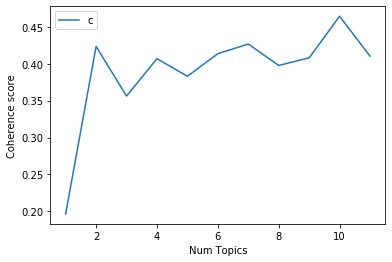

In [27]:
# Visualizamos el resultado del valor de la coherencia por cada topic
# de manera que el topic con mayor coherencia es el valor óptimo para el modelo
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " con Coherence Score: ", round(cv, 4))

Num Topics = 1  con Coherence Score:  0.1966
Num Topics = 2  con Coherence Score:  0.4235
Num Topics = 3  con Coherence Score:  0.3562
Num Topics = 4  con Coherence Score:  0.4069
Num Topics = 5  con Coherence Score:  0.383
Num Topics = 6  con Coherence Score:  0.4137
Num Topics = 7  con Coherence Score:  0.4266
Num Topics = 8  con Coherence Score:  0.3977
Num Topics = 9  con Coherence Score:  0.408
Num Topics = 10  con Coherence Score:  0.4643
Num Topics = 11  con Coherence Score:  0.4103


    Según estos resultados, el óptimo num_topics es 10 con mayor Coherence Score a 0.4643.
    Sin embargo, podríamos optar por:
    
    - num_topic = 7 (Coherence Score:  0.4266) con posición a 6.
    
    Pero este resultado es similar con num_topics = 2 (Coherence Score:  0.4235) y como partimos de un df formado
    por reviews de Amazaon de 4 subsets, con al menos 4 topics diferentes.
    
    Finalmente optamos por num_topics = 10 y así comprobamos si existe solapamiento de los topics.

In [29]:
# Modelo LDA de gensim con el nº óptimo de topics seleccionados (num_topics a 10 con la posición 9)
num_topics = 10
optimal_model_id = 9

# Modelo con el óptimo nº de topics teniendo en cuenta la posición
optimal_model = model_list[optimal_model_id]

In [30]:
# Get a representation for selected topics
optimal_model.show_topics(num_topics)

[(0,
  '0.007*"stud" + 0.005*"kelis" + 0.005*"hands" + 0.005*"best" + 0.004*"door" + 0.004*"rock" + 0.004*"slash" + 0.004*"want" + 0.004*"arch" + 0.003*"performance"'),
 (1,
  '0.023*"knife" + 0.012*"blade" + 0.007*"product" + 0.006*"thumb" + 0.005*"handle" + 0.004*"getting" + 0.004*"water" + 0.004*"little" + 0.004*"star" + 0.004*"sent"'),
 (2,
  '0.007*"amazon" + 0.007*"rifle" + 0.006*"water" + 0.006*"pocket" + 0.006*"bought" + 0.006*"weight" + 0.005*"work" + 0.005*"product" + 0.005*"protein" + 0.005*"right"'),
 (3,
  '0.011*"product" + 0.007*"work" + 0.006*"works" + 0.006*"sure" + 0.005*"better" + 0.005*"feel" + 0.005*"skin" + 0.004*"shave" + 0.004*"hair" + 0.004*"days"'),
 (4,
  '0.058*"quot" + 0.015*"songs" + 0.008*"albums" + 0.007*"music" + 0.007*"rock" + 0.006*"track" + 0.006*"song" + 0.006*"love" + 0.005*"tracks" + 0.005*"sound"'),
 (5,
  '0.021*"size" + 0.014*"wear" + 0.011*"shoes" + 0.011*"small" + 0.010*"comfortable" + 0.009*"bought" + 0.008*"look" + 0.008*"ordered" + 0.008*"

In [31]:
# Conversión en pandas y muestra por topics las palabras o términos con mayor importancia
word_dict = {};
for i in range(num_topics):
    words = optimal_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10
0,stud,knife,amazon,product,quot,size,song,light,light,song
1,kelis,blade,rifle,work,songs,wear,songs,pads,product,band
2,hands,product,water,works,albums,shoes,music,bandages,better,best
3,best,thumb,pocket,sure,music,small,think,seat,look,songs
4,door,handle,bought,better,rock,comfortable,people,jones,head,love
5,rock,getting,weight,feel,track,bought,know,washington,thing,track
6,slash,water,work,skin,song,look,track,briefs,easy,music
7,want,little,product,shave,love,ordered,best,beam,work,single
8,arch,star,protein,hair,tracks,nice,lyrics,lifting,watch,little
9,performance,sent,right,days,sound,little,love,favorite,night,disorder


In [32]:
# Visualizamos las primeras palabras clave de cada topic (ahora en horizontal) junto al peso o valor de importancia
topics = optimal_model.print_topics(num_topics=-1, num_words=5)
t = []
for topic in topics:
    t.append(topic[1].split("+"))

sent_topics_df = pd.DataFrame(data=t,columns=["word1","word2","word3","word4","word5"])
sent_topics_df

,word1,word2,word3,word4,word5
0,"0.007*""stud""","0.005*""kelis""","0.005*""hands""","0.005*""best""","0.004*""door"""
1,"0.023*""knife""","0.012*""blade""","0.007*""product""","0.006*""thumb""","0.005*""handle"""
2,"0.007*""amazon""","0.007*""rifle""","0.006*""water""","0.006*""pocket""","0.006*""bought"""
3,"0.011*""product""","0.007*""work""","0.006*""works""","0.006*""sure""","0.005*""better"""
4,"0.058*""quot""","0.015*""songs""","0.008*""albums""","0.007*""music""","0.007*""rock"""
5,"0.021*""size""","0.014*""wear""","0.011*""shoes""","0.011*""small""","0.010*""comfortable"""
6,"0.019*""song""","0.011*""songs""","0.008*""music""","0.007*""think""","0.006*""people"""
7,"0.009*""light""","0.006*""pads""","0.005*""bandages""","0.004*""seat""","0.004*""jones"""
8,"0.020*""light""","0.009*""product""","0.006*""better""","0.005*""look""","0.005*""head"""
9,"0.010*""song""","0.007*""band""","0.007*""best""","0.007*""songs""","0.005*""love"""


    Topic 1 - las palabras son algo confusas y aunque pueden hacer referencia a la cantante Kelis Rogers
        {best, rock, roll, ....}
        
    Topic 2 - es algo confuso y aunque algunas palabras referencian a utensilios de cocina, no identificó un topic
        {knife, product, thumb, handle, getting, knives, products,...)
 
    Topic 3 - pueden ser reviews referentes a la compra online
        {amazon, pocket, bought, weight, product, protein, purchased,...}
        
    Topic 4 - reviews relacionados con productos para el cuidado personal (piel, afeitado, pelo..)
        {product, work, sure, better, feel, skin, shave, hair, ..}
    
    Topic 5 - reviews relacionados con la música y sus tipos y fans
        {quot, songs, albums, music, rock,.., country, clasicc, fans}
        
    Topic 6 - reviews relacionados con el calzado
        {size, wear, shoes, small, comfortable, bought, ...}
    
    Topic 7 - reviews relacionados con la música y las canciones:
        {song, songs, music, think, people, know, track, best, lyrics,...}
        
    Topic 8 -  podrían ser reviews con referencias a operaciones de belleza aunque es algo confuso
        {light, bandages, seat, lifting, favorite, arrangements,...}
         
    Topic 9 -  reviews con referencias a productos o dispositivos de cuidado  personal
       {light, producto, better, look, head, thing, easy, work, watch, batteries, sleep, device,...}
    
    Topic 10 - reviews relacionados con la música, singles o albums
        {song, band, best, songs, love, track, music, single,....}
        

Con lo cual, según este análisis de los 10 topics, sólo encuento con sentido en 8 topics: 
    
    Topic 3 - compra online (Amazon)  
    Topic 4 - productos o consejos para el cuidado personal
    Topic 5 - música, tipos y fans
    Topic 6 - calzado
    Topic 7 - música y las canciones 
    Topic 8 - operaciones de belleza ¿?     
    Topic 9 - productos o dispositivos de cuidado personal
    Topic 10 - música, singles, albums

Según las palabras obtenidas podríamos intentar lemmatizar para observar si los resultados mejoran a la hora de identificar los topics. 

### Calidad del modelo

#### Perplexity y Coherence Score 

In [33]:
# Perplexity # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  

# Coherence Score del id del óptimo num_topics seleccionadoeste dato ya esta calculado en los apartados anteriores)
print('\nCoherence Score: ', coherence_values[optimal_model_id])


Perplexity:  -8.791433549638652

Coherence Score:  0.46432634955115687


### Visualización del modelo

In [34]:
# Enable the automatic display of visualizations in the IPython Notebook.
pyLDAvis.enable_notebook()
# Transforms the Gensim TopicModel and related corpus and dictionary into the data structures needed for the visualization
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.137748 -0.116209       1        1  21.448414
3     -0.111048 -0.092838       2        1  15.151707
5     -0.134259 -0.102980       3        1  14.180277
4      0.235385 -0.053360       4        1  12.338230
8     -0.118013 -0.016044       5        1   8.249227
9      0.150450 -0.037590       6        1   8.174432
1     -0.089963  0.022505       7        1   6.918766
2     -0.147499  0.027037       8        1   6.571688
0      0.030012  0.187923       9        1   4.257514
7      0.047187  0.181555      10        1   2.709753, topic_info=      Category        Freq           Term       Total  loglift  logprob
660    Default  727.000000           quot  727.000000  30.0000  30.0000
158    Default  587.000000           song  587.000000  29.0000  29.0000
243    Default  319.000000           size  319.000000  28.0000  28.0000
86     Default  495.000000          songs  495.000000  27.0000  27.0000
831    Default  168.000000          knife  168.000000  26.0000  26.0000
957    Default  280.000000          light  280.000000  25.0000  25.0000
444    Default  205.000000           wear  205.000000  24.0000  24.0000
217    Default  364.000000        product  364.000000  23.0000  23.0000
593    Default  154.000000          shoes  154.000000  22.0000  22.0000
664    Default  148.000000    comfortable  148.000000  21.0000  21.0000
143    Default  296.000000          music  296.000000  20.0000  20.0000
814    Default   93.000000          blade   93.000000  19.0000  19.0000
219    Default  222.000000          small  222.000000  18.0000  18.0000
838    Default  136.000000        ordered  136.000000  17.0000  17.0000
389    Default  243.000000          track  243.000000  16.0000  16.0000
756    Default  249.000000         bought  249.000000  15.0000  15.0000
670    Default  161.000000         albums  161.000000  14.0000  14.0000
242    Default   92.000000           shoe   92.000000  13.0000  13.0000
693    Default  139.000000           rock  139.000000  12.0000  12.0000
64     Default  186.000000           band  186.000000  11.0000  11.0000
716    Default  169.000000         tracks  169.000000  10.0000  10.0000
655    Default  141.000000          water  141.000000   9.0000   9.0000
65     Default  324.000000           best  324.000000   8.0000   8.0000
421    Default  215.000000           look  215.000000   7.0000   7.0000
865    Default  142.000000         amazon  142.000000   6.0000   6.0000
414    Default   88.000000           feet   88.000000   5.0000   5.0000
647    Default   79.000000           skin   79.000000   4.0000   4.0000
215    Default  342.000000           love  342.000000   3.0000   3.0000
140    Default  163.000000         lyrics  163.000000   2.0000   2.0000
193    Default   70.000000          shave   70.000000   1.0000   1.0000
1943    Topic1   58.686836         eminem   59.432068   1.5269  -5.9233
4057    Topic1   42.731625      featuring   43.468246   1.5224  -6.2406
2996    Topic1   26.952209           mora   27.700983   1.5121  -6.7014
4249    Topic1   23.829567        hendrix   24.563129   1.5092  -6.8246
1683    Topic1   22.987633           club   23.722059   1.5081  -6.8605
1340    Topic1   25.250570         rapper   26.117136   1.5058  -6.7667
3717    Topic1   21.098652         genius   21.832409   1.5053  -6.9463
1514    Topic1   27.651731          elton   28.622421   1.5050  -6.6758
2182    Topic1   20.247278       majority   20.983133   1.5038  -6.9875
1815    Topic1   21.047075         verses   21.825157   1.5032  -6.9487
3216    Topic1   19.307310           drug   20.041763   1.5022  -7.0350
10462   Topic1   18.160070       jennifer   18.893475   1.4999  -7.0963
8992    Topic1   17.621374         hudson   18.366301   1.4981  -7.1264
15476   Topic1   17.109083          rocko   17.842457   1.4975  -7.1559
14372   Topic1   17.106426          davis   17.839840   1.4975  -7.15

In [35]:
pyLDAvis.save_html(vis, '../notebooks/results/topics_reviewsamazon_n10.html')

Cada burbuja en la parte izquierda representa un topic. 

Cuanto más grande la burbuja, más predominante es ese topic. En nuestra representación y según el apartado final "Distribución de topics en el corpus", los topics con menor distribución son los nº 1 y 8  que están asociados a las burbujas 9 (4.3%) y 10 (2.7%) respectivamente y que efectivamente su tamaño es menor por ejemplo con respecto a las burbujas 1 (21.4%) y 2 (15.2%) que referencian los topics 7 y 4 respectivamente.

Mapeo entre burbujas y topics:

    Burbuja 1  representa el Topic nº 7  (reviews de música y las canciones)
    Burbuja 2  representa el Topic nº 4  (reviews de productos o consejos para el cuidado personal)
    Burbuja 3  representa el Topic nº 6  (reviews sobre el calzado)
    Burbuja 4  representa el Topic nº 5  (reviews de cuotas de mercado de música, tipos y fans)
    Burbuja 5  representa el Topic nº 9  (reviews sobre productos o dispositivos de cuidado personal)
    Burbuja 6  representa el Topic nº 10 (reviews sobre  música, singles, albums)
    Burbuja 7  representa el Topic nº 2  
    Burbuja 8  representa el Topic nº 3  (relacionados con la compra online- Amazon) 
    Burbuja 9  representa el Topic nº 1
    Burbuja 10 representa el Topic nº 8  (operaciones de belleza)

Si posicionamos el cursor sobre una burbuja, las palabras y el gráfico de la derecha se actualizan y estas palabras son las palabras clave más importantes para el topic asociado a dicha burbuja.

Si seleccionamos una palabra del gráfico de barras, observamos las burbujas en las cuales aparece por orden de importancia según el tamaño de la(s) burbuja(s), Por ejemplo si seleccionamos la palabra song en la burbuja 1 vemos que también se encuentra en las burbujas 4 y 6 cuyos topics están relacionados con el topic de la música.

Algunas burbujas que se solapan como las nº 2 y 3, o 9 y 10,  y algunas otras como las nº 5, 7 y 8, todas ellas porque comparten las mismas palabras.

Si se restringe el λ se observa las palabras con más importancia en todos los topics y podemos deducir en este caso que la burbuja 9 referencia a cantantes tales como Kelis, Kravitz o la banda sonora de la película Blade. O por ejemplo en la burbuja 8 asociada a review compra online-Amazon, podemos comprobar que además existen referencias a proteinas, orgánico, píldoras, atención medica, leche, bebida, comida, o incluso láser.


### Topic dominante por texto

In [36]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [37]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=processed_texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.2417,"light, product, better, look, head, thing, eas...","[watch, says, like, pulling, teeth, interface,..."
1,1,3.0,0.9663,"amazon, rifle, water, pocket, bought, weight, ...","[hatchet, arrived, covered, oily, substance, s..."
2,2,10.0,0.6222,"song, band, best, songs, love, track, music, s...","[forget, plodding, octave, mooody, blues, come..."
3,3,1.0,0.3138,"stud, kelis, hands, best, door, rock, slash, w...","[room, cleaning, guns, little, fuzzy, surface,..."
4,4,10.0,0.5194,"song, band, best, songs, love, track, music, s...","[reason, gave, stars, like, took, emotion, sor..."
5,5,4.0,0.8475,"product, work, works, sure, better, feel, skin...","[start, saying, better, quality, epilators, wi..."
6,6,4.0,0.5502,"product, work, works, sure, better, feel, skin...","[striper, clips, work, great, wanted, bend, wo..."
7,7,3.0,0.6279,"amazon, rifle, water, pocket, bought, weight, ...","[good, product, emitting, fragrant, smell, pur..."
8,8,6.0,0.4994,"size, wear, shoes, small, comfortable, bought,...","[foot, size, order, true, stretch, material, e..."
9,9,6.0,0.4976,"size, wear, shoes, small, comfortable, bought,...","[looked, like, picture, smelled, funny, wanted..."


    Para el documento nº 1 --> topic dominante es el nº 3 (compra online- Amazon) 
    Para el documento nº 2, 4, 10 y 15 --> topic dominante es el nº 10 (reviews sobre  música, singles, albums), con mayor % en Doc.nº 10 0.9397
    Para el documento nº 5, 6 y 11 --> topic dominante es el nº 4 con reviews de productos o consejos para el cuidado personal
    Para el documento nº 8, 9, 12, 16 y 17 --> topic dominante es el nº 6 reviews sobre el calzado 

### Documento más representativo por topic

In [38]:
sent_topics_sorteddf_lda = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_lda = pd.concat([
        sent_topics_sorteddf_lda,
        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
        axis=0)

# Reset Index    
sent_topics_sorteddf_lda.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_lda.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_lda

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.9938,"stud, kelis, hands, best, door, rock, slash, w...","[mientras, grupos, ingleses, mediados, redescu..."
1,2.0,0.9832,"knife, blade, product, thumb, handle, getting,...","[given, knife, star, rating, kershaw, chive, l..."
2,3.0,0.9842,"amazon, rifle, water, pocket, bought, weight, ...","[manufacture, packed, sunny, goodness, tiny, p..."
3,4.0,0.9957,"product, work, works, sure, better, feel, skin...","[tend, prefer, rotary, shavers, foil, usual, w..."
4,5.0,0.9949,"quot, songs, albums, music, rock, track, song,...","[albums, disc, collection, contains, long, ver..."
5,6.0,0.9926,"size, wear, shoes, small, comfortable, bought,...","[edited, excited, athletic, type, shoe, wasn, ..."
6,7.0,0.9956,"song, songs, music, think, people, know, track...","[love, carpenters, love, starting, little, tir..."
7,8.0,0.9563,"light, pads, bandages, seat, jones, washington...","[wanted, wake, light, hard, time, waking, ligh..."
8,9.0,0.9797,"light, product, better, look, head, thing, eas...","[great, blood, pressure, machine, easy, apply,..."
9,10.0,0.9895,"song, band, best, songs, love, track, music, s...","[honest, like, songs, downtown, train, greatly..."


### Distribución de topics en el corpus

In [39]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), num_topics)
df_topic_contribution = pd.DataFrame({'topic': topic_contribution.index, 'contribution': topic_contribution})
df_topic_contribution.reset_index(drop=True, inplace=True)

# Show
df_topic_contribution

,topic,contribution
0,6.0,0.2720
1,4.0,0.1728
2,7.0,0.1580
3,9.0,0.0808
4,5.0,0.0768
5,3.0,0.0704
6,2.0,0.0684
7,10.0,0.0544
8,1.0,0.0272
9,8.0,0.0192


### Conclusiones

A partir de un dataset de 2500 reviews se ha aplicado la técnica topic modeling para la detección de los principales topics o temas, a los cuales referencian los usuarios desde la red y cuya interpretabilidad puede ser algo confusa:

    Topic 1 - cantantes tales como Kelis, Kravitz o la banda sonora de la película Blade
    Topic 3 - compra online (Amazon)  
    Topic 4 - productos o consejos para el cuidado personal
    Topic 5 - cuotas de mercado de música, tipos y fans
    Topic 6 - calzado
    Topic 7 - música y las canciones 
    Topic 8 - operaciones de belleza     
    Topic 9 - productos o dispositivos de cuidado personal
    Topic 10 - música, singles, albums
    
En este caso observamos que uno de los topics principales es la música, dividido 4 subtopics (Topic 1 cantantes, Topic 5 coutas de mercado, Topic 7 música y canciones y el Topic 10 con singles y álbumes.

Un segundo topic, correspondería al cuidado personal con varios subtopics Topic 4, 8 y 9

Un tercer topic, es la moda en el que se podría englobar el topic del calzado 

No habría encontado referencia a reviews de sports and outdoors con esta muestra. 

In [40]:
# Guardamos el dataframe df_amazon_filter para aplicar lemmatización en el siguiente notebook
# to_pickle: Pickle (serialize) object to file.
df_amazonfilter.to_pickle('df_amazonfilter.pkl')

In [41]:
# Comprobamos que al cargar el fichero pkl no hay diferencias
# Load pickled pandas object (or any object) from file.
df_newamazonfilter = pd.read_pickle('df_amazonfilter.pkl')

# Comprobamos que ambos dataframes son iguales
print(f'Dimensiones del dataframe df_newamazonfilter: ', df_newamazonfilter.shape)
print(f'Dimensiones del dataframe df_amazonfilter: ', df_amazonfilter.shape)

df_amazonfilter.equals(df_newamazonfilter)

Dimensiones del dataframe df_newamazonfilter:  (2500, 1)
Dimensiones del dataframe df_amazonfilter:  (2500, 1)


True